# Shows results for 510 cropped images of wheat plots

In [362]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

import import_ipynb
import wheat_dataset
from wheat_dataset import WheatDataset

from utils_dataset import get_transform_albumentation, get_transform_imgaug_img, get_transform_torch_img
from detection_transforms import Compose, PILToTensor, ConvertImageDtype, RandomHorizontalFlip
from detection_utils import collate_fn

import torch
import torchvision
from torchvision import transforms as T
from torchvision.utils import draw_segmentation_masks
from torchvision.utils import draw_bounding_boxes
import torchvision.ops as ops

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import numpy as np
import math
import copy
import cv2
import os
import time

# Main Functions

In [363]:
# prediction of model   ->    returns dictionary
def predict_image_window(model, image_window, score_threshold):
    # prediction
    image_window = Image.fromarray(image_window)
    image_window = get_transform_torch_img(image_window).cuda() / 255
    prediction = model([image_window])

    # save as tensor
    prediction[0]["boxes"] = torch.Tensor(prediction[0]["boxes"].cpu().detach().numpy())
    prediction[0]["scores"] = torch.Tensor(prediction[0]["scores"].cpu().detach().numpy())
    prediction[0]["labels"] = torch.Tensor(prediction[0]["labels"].cpu().detach().numpy())
    prediction[0]["masks"] = torch.Tensor(prediction[0]["masks"].cpu().detach().numpy())

    # remove predictions with small probability (score_threshold)
    prediction[0]["boxes"] = prediction[0]["boxes"][prediction[0]["scores"] > score_threshold]
    prediction[0]["labels"] = prediction[0]["labels"][:len(prediction[0]["boxes"])]
    prediction[0]["masks"] = prediction[0]["masks"][prediction[0]["scores"] > score_threshold]
    prediction[0]["scores"] = prediction[0]["scores"][:len(prediction[0]["boxes"])]

    return prediction[0]

In [364]:
# checks if bounding boxes are on the left or right overlapping side of an sub-image
def get_overlapping_boxes_vertical(x1, y1, x2, y2):
    if (y1 >= 0 and y2 <= 40):
        return True
    elif (y1 >= 240 and y2 <= 280):
        return False
    else:
        return "_"

In [365]:
# # checks if bounding boxes are on the top or bottom overlapping side of an sub-image
# def get_overlapping_boxes_horizontal(x1, y1, x2, y2):
#     if (x1 >= 0 and x2 <= 40):
#         return True
#     elif (x1 >= 240 and x2 <= 280):
#         return False
#     else:
#         return "_"

In [366]:
# recalculate predicted boxes on 280x280 images onto position of original 521x1721 image    ->  returns predictions dictionary with updated boxes
def recalculate_bbs(predictions, num_columns):
    for i, pred in enumerate(predictions):
        left_overlaps, right_overlaps, left_scores, right_scores = [], [], [], []
        scores = copy.deepcopy(pred["scores"])
        for j, box in enumerate(pred["boxes"]):
            x1, y1, x2, y2 = copy.deepcopy(box)
            # Calculate the row and column index of the current prediction
            row_idx = int(i % (len(predictions) // num_columns))
            col_idx = i // (len(predictions) // num_columns)
            # Calculate the new coordinates based on the row and column index
            new_x1 = x1 + col_idx * 120
            new_y1 = y1 + row_idx * 240
            new_x2 = x2 + col_idx * 120
            new_y2 = y2 + row_idx * 240
            pred["boxes"][j] = torch.stack([new_x1, new_y1, new_x2, new_y2])
            # Checks for the overlapping bounding boxes
            left = get_overlapping_boxes_vertical(x1, y1, x2, y2)
            if left == True:
                left_overlaps.append(torch.stack([new_x1, new_y1, new_x2, new_y2]))
                left_scores.append(scores[j])
            elif left == False:
                right_overlaps.append(torch.stack([new_x1, new_y1, new_x2, new_y2]))
                right_scores.append(scores[j])

        if len(left_overlaps) > 0:
            pred["left_border"] = torch.stack(left_overlaps)
            pred["left_scores"] = torch.stack(left_scores)
        else:
            left_overlaps.append(torch.tensor([0, 0, 0, 0]).float())
            left_scores.append(torch.tensor(0).float())
            pred["left_border"] = torch.stack(left_overlaps)
            pred["left_scores"] = torch.stack(left_scores)

        if len(right_overlaps) > 0:
            pred["right_border"] = torch.stack(right_overlaps)
            pred["right_scores"] = torch.stack(right_scores)
        else:
            right_overlaps.append(torch.tensor([0, 0, 0, 0]).float())
            right_scores.append(torch.tensor(0).float())
            pred["right_border"] = torch.stack(right_overlaps)
            pred["right_scores"] = torch.stack(right_scores)

    return predictions

In [367]:
# calculate center and pixel area of bounding boxes   ->  returns three lists: x, y and pixel area for bounding boxes
def get_box_center(boxes):
    x_center, y_center, pixel_areas = [], [], []
    for box in boxes:
        x1, y1, x2, y2 = box
        # calculate values
        x_mid = x1 + ((x2-x1) / 2)
        y_mid = y1 + ((y2-y1) / 2)
        pixel_area = (x2-x1) * (y2-y1)
        # append values to lists
        x_center.append(x_mid)
        y_center.append(y_mid)
        pixel_areas.append(pixel_area)
    return x_center, y_center, pixel_areas

In [368]:
# removes overlapping boxes across all boxes and associates sub-image to box    ->     returns dict with boxes, scores and boxes with sub-image association
def remove_overlapping_boxes(predictions, iou_threshold=0.5):

    # Collect boxes, masks and associated sub-image in a list
    boxes_association = []
    for i, prediction in enumerate(predictions):
        for j, boxes in enumerate(prediction["boxes"]):
            boxes_association.append((boxes, i))

    boxes = [torch.clone(prediction['boxes']) for prediction in predictions]
    scores = [torch.clone(prediction['scores']) for prediction in predictions]

    left_border = [torch.clone(prediction['left_border']) for prediction in predictions]
    right_border = [torch.clone(prediction['right_border']) for prediction in predictions]
    left_scores = [torch.clone(prediction['left_scores']) for prediction in predictions]
    right_scores = [torch.clone(prediction['right_scores']) for prediction in predictions]

    # Concat all values
    boxes = torch.cat(boxes)
    scores = torch.cat(scores)

    # Apply NMS to the boxes
    keep = ops.nms(boxes, scores, iou_threshold)

    # Filter out boxes and scores that didn't meet the score threshold
    boxes = boxes[keep]
    scores = scores[keep]
    boxes_association = [boxes_association[i] for i in keep]

    overlap_boxes_kept, overlap_scores_kept = [], []

    for i in range(len(right_border)):
        if i == len(right_border)-1:
            break
        # left border
        if i % 7 == 0:
            keep = ops.nms(left_border[i], left_scores[i], iou_threshold)
            overlap_boxes_kept.append(left_border[i][keep])
            overlap_scores_kept.append(left_scores[i][keep])
        # right border
        if i % 7 == 6:
            keep = ops.nms(right_border[i], right_scores[i], iou_threshold)
            overlap_boxes_kept.append(right_border[i][keep])
            overlap_scores_kept.append(right_scores[i][keep])
        # middle
        else:
            both_overlaps = torch.cat((right_border[i], left_border[i+1]), dim=0)
            both_scores = torch.cat((right_scores[i], left_scores[i+1]), dim=0)
            keep_overlap_area = ops.nms(both_overlaps, both_scores, iou_threshold)
            both_kept_boxes = both_overlaps[keep_overlap_area]
            both_kept_scores = both_scores[keep_overlap_area]
            overlap_boxes_kept.append(both_kept_boxes)
            overlap_scores_kept.append(both_kept_scores)

    # Return the filtered boxes, scores, and masks as a dictionary
    predictions = {
        'scores': scores,
        'boxes': boxes,
        'association': boxes_association,
        'left_border': left_border,
        'right_border': right_border,
        'overlap_boxes_kept': overlap_boxes_kept,
        'overlap_scores_kept': overlap_scores_kept
    }

    return predictions

In [369]:
# get count and paths for all 510 images
def get_files(root_path):
    dir_path = r'/data/departments/schoen/roessle/HSWT_Aehrenzaehlen/images_full_plots/'
    all_paths = []
    count = 0
    # Iterate directory
    for path in os.listdir(dir_path):
        all_paths.append(root_path + path)
        if os.path.isfile(os.path.join(dir_path, path)):
            count += 1
    print('File count:', count)
    return(all_paths)

# Main Function and Plots

File count: 510
1
/data/departments/schoen/roessle/HSWT_Aehrenzaehlen/images_full_plots/DOP_AD22_HZ_D10_RGB_18mm_UTM32_____multi_band___parcel_10108_buff_0.0.tif


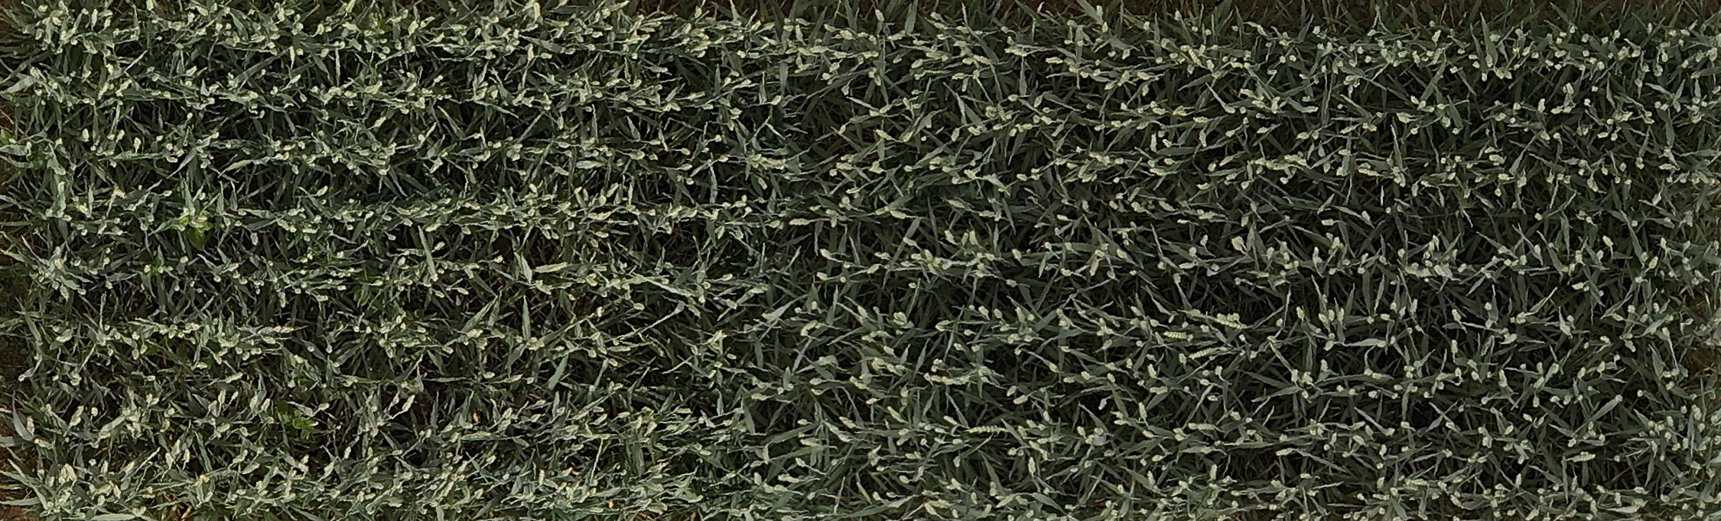

In [370]:
model_path = "/home/emj6571/model/model_5_epochs_2022-12-14_v2.pt"
model = torch.load(model_path)

root_path = "/data/departments/schoen/roessle/HSWT_Aehrenzaehlen/images_full_plots/"

all_paths = get_files(root_path)
images_list = []

indices = torch.randperm(len(all_paths)).tolist()
number_of_images = len(all_paths)

# for path in all_paths:
#     if path == "/data/departments/schoen/roessle/HSWT_Aehrenzaehlen/images_full_plots/DOP_AD22_HZ_D10_RGB_18mm_UTM32_____multi_band___parcel_10108_buff_0.0.tif":
#         image = path

# preprocess images
for index in indices[:1]:
    image = all_paths[index]
    im = Image.open(image)
    im = im.rotate(85, expand=True)

    # (left,top), (right,bottom)
    im = im.crop((350, 325, 2600, 1025))
    im = im.resize(size=(1721, 521))

    image = np.array(im)
    image = image.transpose(1,0,2)
    images_list.append(image)
        
print(len(images_list))
print(all_paths[0])
im

In [371]:
score_threshold = 0.7
iou_threshold = 0.2
mask_threshold = 0.5

In [372]:
def main(model, image_list, score_threshold, iou_threshold, mask_threshold):
    COLORS = [(255,0,0), (0,255,0), (0,0,255)]
    counter = 0
    image_counter = 0

    # sliding window 
    results = []
    for image in image_list:
        images = []
        # tmp = image
        step_size_width = 120
        step_size_heigth = 240
        num_columns = math.floor(image.shape[1] / (280-120))
        (w_width, w_height) = (280, 280)
        for x in range(0, image.shape[1] - w_width , step_size_width):       # width
            for y in range(0, image.shape[0] - w_height, step_size_heigth):    # heigth
                image_window = image[y:y + w_height, x:x + w_width, :]
                images.append(image_window)
                # cv2.rectangle(tmp, (x, y), (x + w_width, y + w_height), COLORS[counter], 2)   # show sub-image crops
            counter += 1
        sub_image_count = len(images)

        # predictions for sliding window     
        predictions = []
        parcel_count = []
        for i, image in enumerate(images, start=1):
            prediction = predict_image_window(model, image, score_threshold)
            predictions.append(prediction)
            parcel_count.append(len(prediction["boxes"][prediction["scores"] > score_threshold]))

        # print(f"Standard Deviation of all parcels: {np.round(np.std(parcel_count), 5)}")
        print(f"Image Number: {image_counter}")

        predictions = recalculate_bbs(predictions, num_columns)

        old_boxes = []
        for pred in predictions:
            old_boxes.append(pred["boxes"])

        predictions = remove_overlapping_boxes(predictions, iou_threshold)

        x_filtered, y_filtered, pixel_areas = get_box_center(predictions["boxes"])
        n_wheatheads = len(predictions["association"])
        
        results.append([images, predictions, n_wheatheads, predictions["boxes"], x_filtered, y_filtered, pixel_areas, old_boxes])
        image_counter += 1
        
    return results

In [373]:
start = time.time()
results = main(model, images_list, score_threshold, iou_threshold, mask_threshold)
end = time.time()
print("")
print(f"Time elapsed: {np.round(end - start, 2)} seconds")
# took 1767.7 seconds for 510 images

Image Number: 0

Time elapsed: 5.04 seconds


In [374]:
# def main_image_window(model, image_list, score_threshold, iou_threshold, mask_threshold):
#     COLORS = [(255,0,0), (0,255,0), (0,0,255)]
#     counter = 0
#     image_counter = 0

#     # sliding window 
#     results = []
#     for image in image_list:
#         images = []
#         image_window = image[520:800, 120:400, :]
#         images.append(image_window)
#         counter += 1
#         sub_image_count = len(images)

#         # predictions for sliding window     
#         predictions = []
#         parcel_count = []
#         for i, image in enumerate(images, start=1):
#             prediction = predict_image_window(model, image, score_threshold)
#             predictions.append(prediction)
#             parcel_count.append(len(prediction["boxes"][prediction["scores"] > score_threshold]))

#         # print(f"Standard Deviation of all parcels: {np.round(np.std(parcel_count), 5)}")
#         print(f"Image Number: {image_counter}")

#         # predictions = recalculate_bbs(predictions, num_columns)

#         old_boxes = []
#         for pred in predictions:
#             old_boxes.append(pred["boxes"])

#         predictions = remove_overlapping_boxes(predictions, iou_threshold)
#         x_filtered, y_filtered, pixel_areas = get_box_center(predictions["boxes"])
#         n_wheatheads = len(predictions["boxes"])
        
#         results.append([images, predictions, n_wheatheads, predictions["boxes"], x_filtered, y_filtered, pixel_areas, old_boxes])
#         image_counter += 1
        
#     return results

In [375]:
# start = time.time()
# results_image_window = main_image_window(model, images_list, score_threshold, iou_threshold, mask_threshold)
# end = time.time()
# print("")
# print(f"Time elapsed: {np.round(end - start, 8)} seconds")
# # took 80.8 seconds for 510 images

In [376]:
def sort_bounding_boxes(bounding_boxes):
    sorted_indices = torch.argsort(bounding_boxes[:, 1]*1000 + bounding_boxes[:, 0])
    sorted_bounding_boxes = bounding_boxes[sorted_indices]
    return sorted_bounding_boxes

In [377]:
def filter_bounding_boxes(bounding_boxes, max_diff=0.5):
    new_boxes = []
    for i, box in enumerate(bounding_boxes):
        if i == bounding_boxes.shape[0]-1:
            break

        x11, y11, x21, y21 = box
        x12, y12, x22, y22 = bounding_boxes[i+1]

        x1_d = torch.abs(x11-x12)
        y1_d = torch.abs(y11-y12)
        x2_d = torch.abs(x21-x22)
        y2_d = torch.abs(y21-y22)

        if x1_d <= max_diff and y1_d <= max_diff and x2_d <= max_diff and y2_d <= max_diff:
            new_boxes.append(i)

    return torch.as_tensor(new_boxes)

In [378]:
# Plot image border prediction for index idx
def image_plot(results, images_list, idx):
    images, predictions, n_wheatheads, filtered_boxes, x_filtered, y_filtered, filtered_mask, old_boxes = results[idx]
    image = images_list[idx]

    left_values, right_values, combined_values = [], [], []
    left_v, right_v, combined_v = [], [], []

    # retrieve correct left and right spikes
    for i, sublist in enumerate(predictions["left_border"]):
        if i % 7 == 0:
            pass
        if i % 7 == 6:
            pass
        else:            
            left_values.append(len(predictions["left_border"][i+1]))
            right_values.append(len(predictions["right_border"][i]))
            left_v.append(predictions["left_border"][i+1])
            right_v.append(predictions["right_border"][i])
            
    # retrieve correct comined spikes
    for i, sublist in enumerate(predictions["overlap_boxes_kept"]):
        if i % 8 == 0 or i % 8 == 7:
            pass
        else:
            combined_values.append(len(sublist))
            combined_v.append(sublist)

    # setup small "table" of sub-image overlap values
    all_values = torch.as_tensor([left_values, right_values, combined_values])
    print(all_values)

    left_border_boxes = torch.stack([item for sublist in left_v for item in sublist])
    right_border_boxes = torch.stack([item for sublist in right_v for item in sublist])
    both_border_boxes = torch.stack([item for sublist in combined_v for item in sublist])

    sorted_tensor = sort_bounding_boxes(both_border_boxes)
    filtered_tensor = filter_bounding_boxes(sorted_tensor)

    new_boxes = sorted_tensor[filtered_tensor]
    new_boxes_1 = sorted_tensor[filtered_tensor+1]

    image = image.transpose(1,0,2)

    transform = T.Compose([T.ToTensor(), T.ConvertImageDtype(torch.uint8)])
    torch_img = transform(image)

    # rechts -> rot; links -> blau
    torch_img_boxes_right = draw_bounding_boxes(torch_img.permute(0,2,1), right_border_boxes, colors=(255,0,0))
    torch_img_boxes_left = draw_bounding_boxes(torch_img.permute(0,2,1), left_border_boxes, colors=(0,0,255))
    torch_img_boxes_left_right = draw_bounding_boxes(torch_img_boxes_right, left_border_boxes, colors=(0,0,255))
    torch_img_both_borders = draw_bounding_boxes(torch_img.permute(0,2,1), both_border_boxes, colors=(0,255,0))
    torch_img_filtered_boxes = draw_bounding_boxes(torch_img.permute(0,2,1), new_boxes, colors=(0,255,0))
    torch_img_filtered_boxes_1 = draw_bounding_boxes(torch_img_filtered_boxes, new_boxes_1, colors=(255,0,0))

    # f1 = plt.figure(figsize=(30,16))
    # ax = f1.add_subplot(1,1,1)
    # plt.title(f"Left border of extracted predictions on sub-images", fontsize=20)
    # implot1 = plt.imshow(torch_img_filtered_boxes_1.permute(2,1,0))

    # f2 = plt.figure(figsize=(30,16))
    # # ax = f2.add_subplot(1,1,1)
    # plt.title(f"Right border of extracted predictions on sub-images", fontsize=20)
    # implot2 = plt.imshow(torch_img_boxes_right.permute(2,1,0))

    f3 = plt.figure(figsize=(30,16))
    # ax = f2.add_subplot(1,1,1)
    plt.title(f"Combined extracted predictions after IoU-Removal on sub-images", fontsize=20)
    implot3 = plt.imshow(torch_img_both_borders.permute(2,1,0))
    plt.show(block=True)

    return filtered_tensor, new_boxes, new_boxes_1, both_border_boxes

tensor([[16, 16, 20, 20, 18, 15, 13, 16, 14, 18, 14, 17, 19, 13, 11, 15, 17, 17],
        [16, 18, 19, 17, 14, 11, 12, 14, 16, 20, 13, 12, 17,  9, 15, 16, 17, 14],
        [19, 21, 23, 21, 20, 16, 16, 19, 19, 21, 17, 18, 21, 15, 17, 17, 21, 18]])


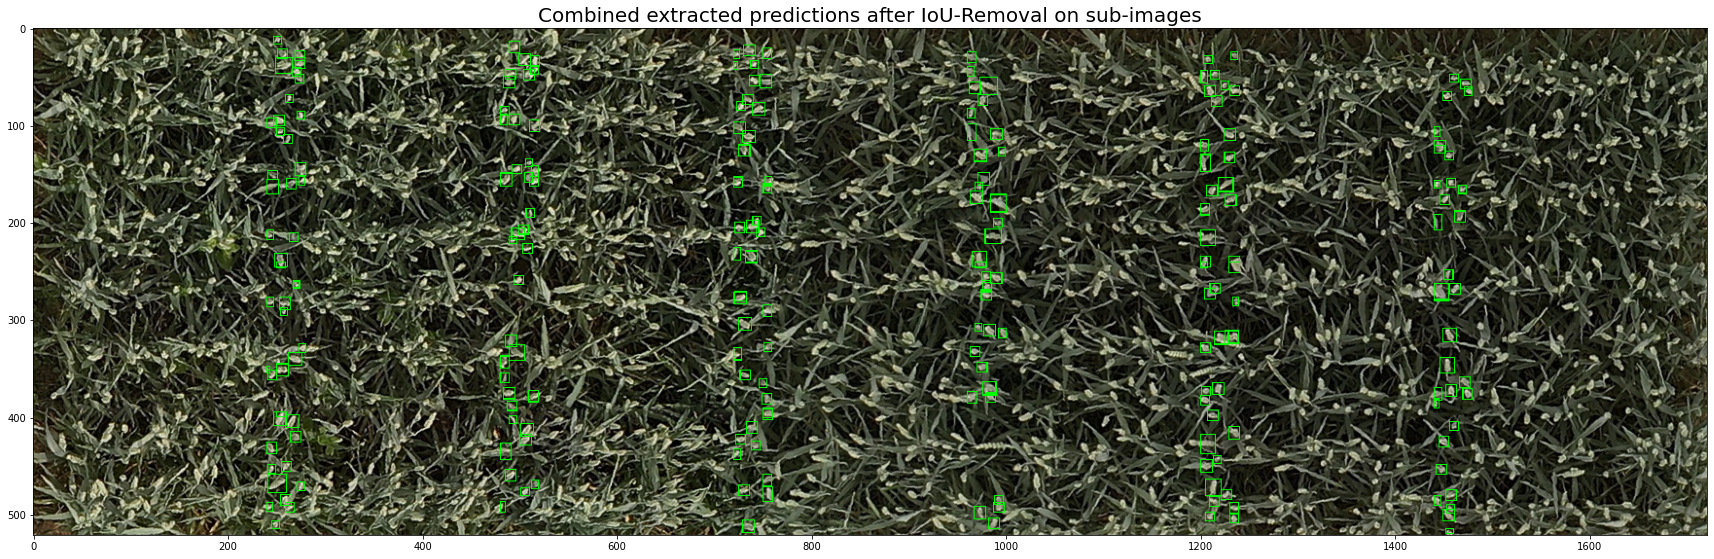

In [379]:
"""Single Plot; benötigt Masken, welche in dieser Datei wegen Speichergründen nicht abgespeichert werden"""
yes = True
if yes:
    filtered_tensor, n1, n2, both_border_boxes = image_plot(results, images_list, 0)

In [174]:
filtered_tensor.shape

torch.Size([50])

In [124]:
filtered_tensor

tensor([162, 168, 180, 182, 238, 254, 266])

In [155]:
comb = torch.cat((n1, n2))
scores = torch.rand(comb.shape[0])

In [158]:
comb.shape

torch.Size([166, 4])

In [442]:
def intersection_area(box1, box2):
    # Calculate the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Calculate the width and height of the intersection rectangle
    width = max(0, x2 - x1)
    height = max(0, y2 - y1)
    
    # Calculate the intersection area
    area = width * height
    
    return torch.as_tensor(area)


def area(box):
    x1, y1, x2, y2 = box
    width = x2-x1
    height = y2-y1

    return width * height

In [447]:
filtered_intersection_boxes_ids_deleted = set()
filtered_intersection_boxes_ids = [i for i in range(both_border_boxes.shape[0])]

copies = copy.deepcopy(both_border_boxes.tolist())

my_count = 0

for i in range(len(filtered_intersection_boxes_ids)-1, 0, -1):
    box1 = both_border_boxes[i]
    for j, box2 in enumerate(copies):
        if i == j:
            continue
    
        area_i = area(box1)
        intersection_ij = intersection_area(box1, box2)

        res = intersection_ij / area_i

        if res.item() > 0.5:
            filtered_intersection_boxes_ids_deleted.add(i)
            del copies[i]
            my_count += 1
            break

filtered_intersection_boxes_ids = [i for i in range(len(filtered_intersection_boxes_ids)) if i not in filtered_intersection_boxes_ids_deleted]
filtered_intersection_boxes = both_border_boxes[filtered_intersection_boxes_ids]

In [448]:
print(both_border_boxes.shape)
print(filtered_intersection_boxes.shape)
print(my_count)

torch.Size([339, 4])
torch.Size([222, 4])
117


In [421]:
print(area_i)
print(intersection_ij)

tensor(252.7451)
tensor(235.8925)


In [391]:
bb1 = torch.as_tensor([[1.4, 1.2, 5.6, 5.7], [0.0, 0.0, 2.0, 2.0]])
# bb2 = torch.as_tensor([0.0, 0.0, 2.0, 2.0])

scores = torch.as_tensor([0.8, 0.9])
ops.nms(bb1, scores, 0.2)

tensor([1, 0])

In [159]:
a = ops.nms(comb, scores, iou_threshold)
print(a)
print(a.shape)

tensor([163,  50, 100, 110,  24,  52,  35,  74, 104,   7,  82,  65, 143,  30,
        150,  39, 141, 124, 146,  38,  99,   9,  15,  89,  51,  25, 101,  14,
         12,  71,  37, 159,  68, 164,  42,  44,  49, 162,  47, 123,  64, 155,
        105, 137,   3,  19, 131, 145,  34,  20,   1,  53,  28,  78, 115,  26,
        112,  87, 139,  11, 149,   0, 138,  45,  33, 140,  70,  91, 142,  77,
          5])
torch.Size([71])


# Plot of Image Predictions

In [422]:
# Plot image prediction for index idx
def image_plot(results, images_list, filtered_intersection_boxes, idx):
    images, predictions, n_wheatheads, filtered_boxes, x_filtered, y_filtered, filtered_mask, old_boxes = results[idx]
    image = images_list[idx]

    image = image.transpose(1,0,2)

    transform = T.Compose([T.ToTensor(), T.ConvertImageDtype(torch.uint8)])
    torch_img = transform(image)

    torch_img_boxes = draw_bounding_boxes(torch_img.permute(0,2,1), filtered_intersection_boxes, colors=(255,0,0))
    # torch_img_masks = draw_segmentation_masks(torch_img_boxes, filtered_mask, colors=(0,0,255), alpha=0.5).permute(2,1,0)

    # Plots normal image with boxes
    print(f"Total Wheat Heads: {n_wheatheads}")
    f1 = plt.figure(figsize=(30,16))
    ax = f1.add_subplot(1,1,1)
    plt.title(f"Image of big plot - Wheat count: {n_wheatheads}", fontsize=20)
    implot1 = plt.imshow(torch_img_boxes.permute(2,1,0))
    plt.show(block=True)

Total Wheat Heads: 1506


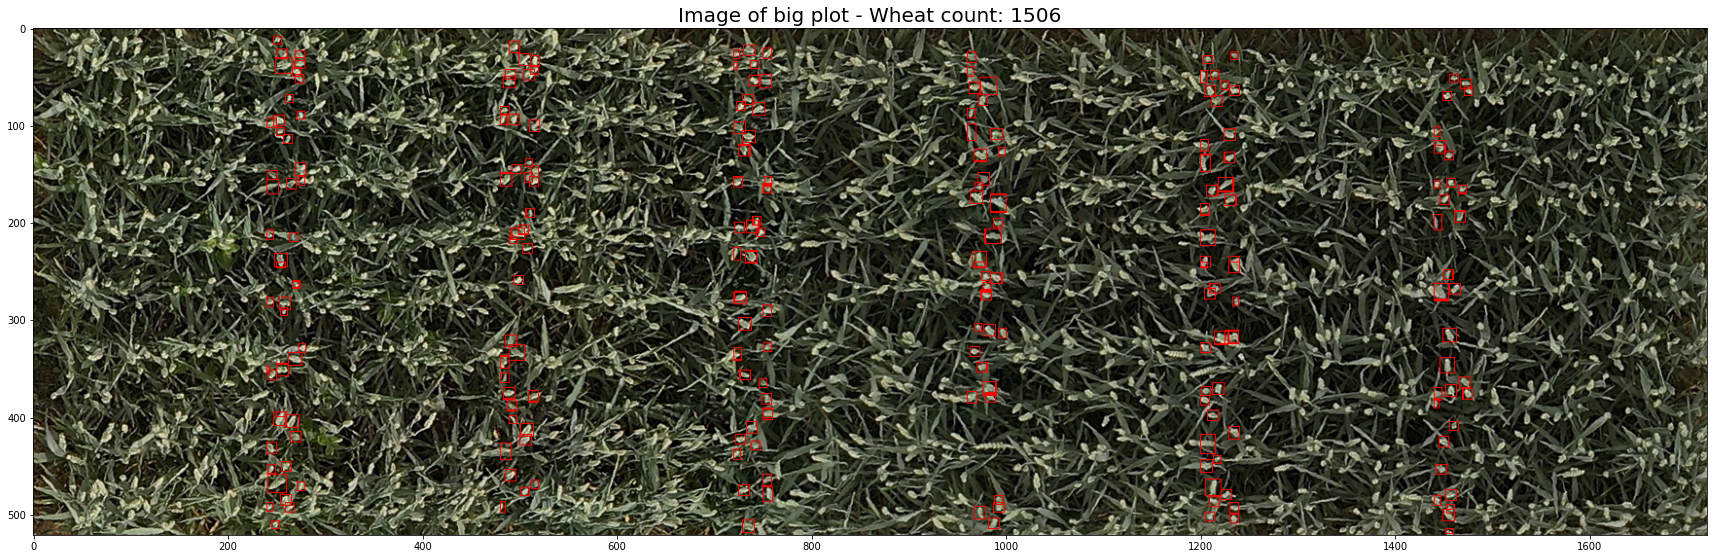

In [450]:
"""Single Plot; benötigt Masken, welche in dieser Datei wegen Speichergründen nicht abgespeichert werden"""
image_plot(results, images_list, both_border_boxes, 0)

# Single Image Evaluation

In [311]:
# estimate single full plot using a single 280x280 plot
def estimation(results, images_list, idx, details=True, plot=True):
    images, predictions, total_wheatheads, filtered_boxes, x_filtered, y_filtered, pixel_area, old_boxes = results[0]
    
    print(f"Total Wheat Heads: {total_wheatheads}\n")

    estimations = []
    row = []
    array = []
    full_plot_size = 521*1721
    small_plot_size = 280*280
    inverse_proportion = full_plot_size / small_plot_size

    for i, image in enumerate(images):

        # Count-based estimation
        count_small_plot = len(old_boxes[i])
        count_estimation = math.floor(inverse_proportion * count_small_plot)

        if details:
            print(f"Sub-image {i}")
            print(f"Part Wheat Heads: {count_small_plot}")
            print(f"Count-based Estimated Wheat Heads: {count_estimation}")
            print(f"Deviation (Count): {count_estimation-total_wheatheads}")
            print(f"Deviation (Percent): {np.round(((count_estimation/total_wheatheads)-1)*100, 2)}%\n")

        estimations.append(count_estimation)
        row.append(count_estimation)

        if (i+1) % 7 == 0:
            array.append(row)
            row = []

    print(f"Min estimation: {min(estimations)} | Index: {estimations.index(min(estimations))}")
    print(f"Max estimation: {max(estimations)} | Index: {estimations.index(max(estimations))}\n")

    print(torch.as_tensor(array))

    boxes = torch.as_tensor(old_boxes[idx])
    boxes_original = draw_bounding_boxes(torch.as_tensor((images_list[0]), dtype=torch.uint8).permute(2,0,1), boxes, colors=(255,0,0))

    # Show single plot if needed
    if plot:
        f = plt.figure(figsize=(30,16))
        plt.title(f"Single Plot: {len(old_boxes[idx])}")
        plt.imshow(boxes_original.permute(2,1,0))
        plt.show(block=True)

In [312]:
"""Single Image result for Approximation"""
estimation(results, images_list, idx=20, details=False, plot=False)

Total Wheat Heads: 1707

Min estimation: 1463 | Index: 11
Max estimation: 1841 | Index: 15

tensor([[1612, 1658, 1589, 1578, 1589, 1749, 1715],
        [1681, 1681, 1566, 1566, 1463, 1761, 1612],
        [1749, 1841, 1749, 1692, 1624, 1807, 1829]])


# Multiple Images Evaluation

In [360]:
def scatter_plot(sub_plot_estimation, full_estimation, subplot_idx):

    r2_list, rmse_list = [], []
    x = np.arange(len(full_estimation))

    if len(sub_plot_estimation) != len(full_estimation):
        for sb_est in sub_plot_estimation:
            r2_list.append(r2_score(full_estimation, sb_est))
            rmse_list.append(np.sqrt(mean_squared_error(full_estimation, sb_est)))
        r2_best = max(r2_list)
        r2_worst = min(r2_list)
        r2_best_index = r2_list.index(r2_best)
        r2_worst_index = r2_list.index(r2_worst)
        rmse_best = min(rmse_list)
        rmse_best_index = rmse_list.index(rmse_best)
        rmse_worst = max(rmse_list)
        rmse_worst_index = rmse_list.index(rmse_worst)
        sub_plot_estimation_best = sub_plot_estimation[r2_best_index]
        sub_plot_estimation_worst = sub_plot_estimation[r2_worst_index]

        print(f"Min R²: {min(r2_list)} - Index: {r2_list.index(min(r2_list))}")
        print(f"Max R²: {max(r2_list)} - Index: {r2_list.index(max(r2_list))}")
        print(f"Min RMSE: {min(rmse_list)} - Index: {rmse_list.index(min(rmse_list))}")
        print(f"Max RMSE: {max(rmse_list)} - Index: {rmse_list.index(max(rmse_list))}")
        print(f"All R² Values: {np.round(r2_list, 2)}")
        print(f"All RMSE Values: {np.round(rmse_list, 2)}")

        f = plt.figure(figsize=(24,10))

        f.add_subplot(1,2,1)
        plt.title(f'Best Sub-Image 3B - RMSE: {rmse_best:.2f}')
        plt.scatter(full_estimation, sub_plot_estimation_best, color='red', label=f'Data Points: {len(sub_plot_estimation)}', s=15)
        plt.plot([min(full_estimation), max(full_estimation)], [min(full_estimation), max(full_estimation)], linestyle='--', linewidth=2, color='grey', label=f'R²: {r2_best:.2f}')
        plt.xlabel('Sliding Window Prediction')
        plt.ylabel('Subplot Upscaling')
        plt.grid(True)
        plt.legend()

        f.add_subplot(1,2,2)
        plt.title(f'Worst Sub-Image 7C - RMSE: {rmse_worst:.2f}')
        plt.scatter(full_estimation, sub_plot_estimation_worst, color='red', label=f'Data Points: {len(sub_plot_estimation)}', s=15)
        plt.plot([min(full_estimation), max(full_estimation)], [min(full_estimation), max(full_estimation)], linestyle='--', linewidth=2, color='grey', label=f'R²: {r2_worst:.2f}')
        plt.xlabel('Sliding Window Prediction')
        plt.ylabel('Subplot Upscaling')
        plt.grid(True)
        plt.legend()

        plt.show(block=True)

    else:
        r2 = r2_score(full_estimation, sub_plot_estimation)
        rmse = np.sqrt(mean_squared_error(full_estimation, sub_plot_estimation))
        r2_index = subplot_idx
        print(f"R²: {r2:.2f}")
        print(f"RMSE: {rmse:.2f}")

        f = plt.figure(figsize=(16,16))
        plt.title(f'Sub-Image 7C - RMSE: {rmse:.2f}')
        plt.scatter(full_estimation, sub_plot_estimation, color='red', label=f'Data Points: {len(sub_plot_estimation)}', s=15)
        plt.plot([min(full_estimation), max(full_estimation)], [min(full_estimation), max(full_estimation)], linestyle='--', linewidth=2, color='grey', label=f'R²: {r2:.2f}')
        plt.xlabel('Sliding Window Prediction')
        plt.ylabel('Subplot Upscaling')
        plt.grid(True)
        plt.legend()

        plt.show(block=True)

In [370]:
def full_estimation(results, subplot_idx, plot_by_index=False):

    average_prediction = np.zeros(shape=(3,7))
    average_total_wheatheads = 0
    full_plot_size = 521*1721
    small_plot_size = 280*280
    inverse_proportion = full_plot_size / small_plot_size
    total_wheatheads_list = []
    subplot_count_dict = {}
    deviation_matrix_step = np.zeros(shape=(21)).reshape((3,7))

    # get counts for each sub-plot and add them across all plots to get the average upscaling values
    for i, full_images in enumerate(results):
        tmp = np.zeros(shape=(21))
        images = full_images[0]
        predictions = full_images[1]
        total_wheatheads = full_images[2]
        total_wheatheads_list.append(total_wheatheads)
        
        for j, image in enumerate(images):
            boxes = full_images[7][j]
            count_small_plot = len(boxes)
            count_estimation = math.floor(inverse_proportion * count_small_plot)
            if j not in subplot_count_dict:
                subplot_count_dict[j] = [count_estimation]
            else:
                subplot_count_dict[j].append(count_estimation)
            tmp[j] += count_estimation
        tmp = tmp.reshape((3,7))
        average_prediction += tmp
        average_total_wheatheads += total_wheatheads
        deviation_matrix_step += ((tmp/total_wheatheads)-1)*100
    average_prediction = average_prediction / len(results)
    average_total_wheatheads = average_total_wheatheads / len(results)

    difference_prediction_total = average_prediction - average_total_wheatheads

    deviation_matrix = ((average_prediction/average_total_wheatheads)-1)*100

    print(f"Average Total Wheatheads (Sliding Window): \n {int(average_total_wheatheads)}\n")
    print(f"Average Prediction: \n {average_prediction}\n")
    print(f"Difference Prediction: \n {difference_prediction_total}\n")
    print(f"Average Difference Prediction: {np.round(np.sum(difference_prediction_total)/21,2)}\n")
    print(f"Deviation (Percent): \n {np.round(deviation_matrix, 2)}\n")
    print(f"Deviation Step (Percent): \n {np.round(deviation_matrix_step/510, 2)}\n")
    print(f"Average Deviation: {np.round(np.sum(deviation_matrix) / 21, 2)}%\n")

    # get items of dict as list for subplot creation
    subplot_values = []
    for key, value in subplot_count_dict.items():
        subplot_values.append(value)
    
    # plot sub-plots by index
    if plot_by_index:
        scatter_plot(subplot_values[subplot_idx], total_wheatheads_list, subplot_idx)
    else:
        scatter_plot(subplot_values, total_wheatheads_list, subplot_idx)

    return average_prediction, average_total_wheatheads

Average Total Wheatheads (Sliding Window): 
 1403

Average Prediction: 
 [[1402.08431373 1429.0627451  1430.21960784 1416.52156863 1400.99215686
  1397.12352941 1365.31960784]
 [1339.42941176 1362.87058824 1373.38431373 1357.92941176 1340.32941176
  1347.36470588 1317.28431373]
 [1376.45882353 1403.20196078 1419.57058824 1409.53137255 1394.58039216
  1399.28823529 1358.4627451 ]]

Difference Prediction: 
 [[-1.20196078e+00  2.57764706e+01  2.69333333e+01  1.32352941e+01
  -2.29411765e+00 -6.16274510e+00 -3.79666667e+01]
 [-6.38568627e+01 -4.04156863e+01 -2.99019608e+01 -4.53568627e+01
  -6.29568627e+01 -5.59215686e+01 -8.60019608e+01]
 [-2.68274510e+01 -8.43137255e-02  1.62843137e+01  6.24509804e+00
  -8.70588235e+00 -3.99803922e+00 -4.48235294e+01]]

Average Difference Prediction: -20.38

Deviation (Percent): 
 [[-0.09  1.84  1.92  0.94 -0.16 -0.44 -2.71]
 [-4.55 -2.88 -2.13 -3.23 -4.49 -3.99 -6.13]
 [-1.91 -0.01  1.16  0.45 -0.62 -0.28 -3.19]]

Deviation Step (Percent): 
 [[-0.08  1.

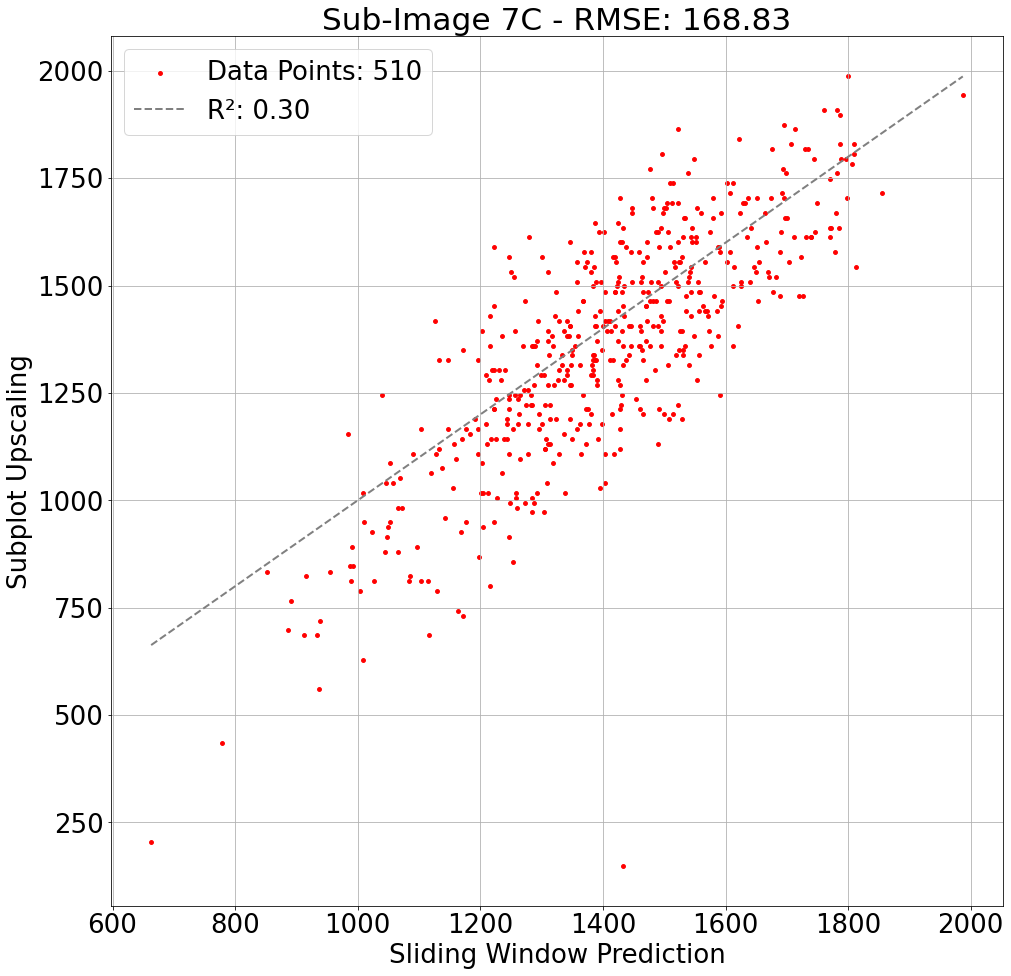

In [371]:
"""Estimation for multiple Images"""
plt.rcParams.update({'font.size': 26})
subplot_idx = 20
average_prediction, average_total_wheatheads = full_estimation(results, subplot_idx, plot_by_index=True)

# Grid for Heatmap

In [ ]:
def get_grid_counts(x_filtered, y_filtered, gridsize_heatmap, cells_w, cells_h):
    # Convert x and y coordinates to NumPy arrays
    x_filtered = np.array(x_filtered)
    y_filtered = np.array(y_filtered)
    
    # Calculate the indices of the grid cells for each point
    x_indices = np.floor(x_filtered / gridsize_heatmap).astype(int)
    y_indices = np.floor(y_filtered / gridsize_heatmap).astype(int)
    
    # Create a 2D array of zeros to store the counts for each grid cell
    grid_counts = np.zeros((cells_w, cells_h), dtype=int)
    
    # Increment the count for each grid cell that contains a point
    for x, y in zip(x_indices, y_indices):
        grid_counts[y][x] += 1
    
    # Transpose the array so that the rows correspond to the y axis and the columns correspond to the x axis
    counts = grid_counts.T
    
    return counts

In [ ]:
# calculates grid size
gridsize_heatmap = 40
cells_w = int(1720 / gridsize_heatmap)
cells_h = int(520 / gridsize_heatmap)

In [ ]:
# get grids for all images
all_grids = []
for parameters in results:
    np_grids = get_grid_counts(parameters[4], parameters[5], gridsize_heatmap, cells_w, cells_h)
    all_grids.append(np_grids)

# Plot of Heatmaps

In [ ]:
# Plots count (and density) heatmap
def heatmaps(results, images_list, all_grids, gridsize_heatmap, plot, idx):
    
    images, predictions, total_wheatheads, filtered_boxes, x_filtered, y_filtered, pixel_area, old_boxes = results[idx]
    
    image = images_list[idx]
    np_grid = all_grids[idx]
    row, column = all_grids[0].shape

    average_counts = np.zeros(shape=(13,43))

    for i in range(len(all_grids)):
        average_counts += all_grids[i]
    
    average_counts = np.round((average_counts / len(all_grids)), 1)

    print(f"Average counts per cell: {np.round(np.sum(average_counts) / (13*43), 1)}")

    # Plot heatmap for average of 100 images
    f = plt.figure(figsize=(30,16))
    f.add_subplot(1,1,1)
    heatmap_big = plt.imshow(average_counts, cmap='YlOrRd')
    for i in range(row):
        for j in range(column):
            plt.text(j, i, average_counts[i][j], ha="center", va="center", color="black", fontsize=15)
    plt.title("Average count heatmap for all plot images", fontsize=20)
    plt.yticks(ticks=np.arange(row), labels=["y{}".format(i+1) for i in range(row)])
    plt.xticks(ticks=np.arange(column), labels=["x{}".format(i+1) for i in range(column)])
    f.colorbar(heatmap_big, shrink=0.5)
    plt.show(block=True)
    
    # Plot heatmap and grid for single image
    if plot:
        f1 = plt.figure(figsize=(30,16))
        f1.add_subplot(1,1,1)
        heatmap_big = plt.imshow(np_grid, cmap='YlOrRd')
        for i in range(row):
            for j in range(column):
                plt.text(j, i, np_grid[i][j], ha="center", va="center", color="black", fontsize=15)
        plt.title("Count heatmap for image of plot", fontsize=20)
        plt.yticks(ticks=np.arange(row), labels=["y{}".format(i+1) for i in range(row)])
        plt.xticks(ticks=np.arange(column), labels=["x{}".format(i+1) for i in range(column)])
        f1.colorbar(heatmap_big, shrink=0.5)
        plt.show(block=True)

        f2 = plt.figure(figsize=(30,16))
        f2.add_subplot(1,1,1)
        plt.title("Grid with wheat head center points for image of plot", fontsize=20)
        plt.plot(x_filtered, y_filtered, 'ro', markersize=3)
        implot3 = plt.imshow(image.transpose(1,0,2), extent=[0, 1721, 521, 0])
        for x in range(0, 1721, gridsize_heatmap):
            plt.plot([x, x], [0, 521], c='b', linewidth=1)
        for y in range(0, 521, gridsize_heatmap):
            plt.plot([0, 1721], [y, y], c='b', linewidth=1)

        plt.show(block=True)

In [ ]:
heatmaps(results, images_list, all_grids, gridsize_heatmap, False, 1)

# Plot and stats for gradient density

In [ ]:
# determines wheat heads for each area  ->  returns two lists of seperated x,y centres for each area and the areas themselfs
def density_division(modified_x, modified_y, width, height, WIDTH_PIXELS, HEIGHT_PIXELS, n_areas, pixel_areas, scaling_factor):
    outer_x, middle_x, inner_x = [], [], []
    outer_y, middle_y, inner_y = [], [], []
    outer_area, middle_area, inner_area = 0,0,0

    for i, x in enumerate(modified_x):
        # outer area
        if x <= WIDTH_PIXELS or x >= (width - WIDTH_PIXELS) or modified_y[i] <= HEIGHT_PIXELS or modified_y[i] >= (height - HEIGHT_PIXELS):
            outer_x.append(x)
            outer_y.append(modified_y[i])
            outer_area += pixel_areas[i]
        # inner area
        elif (x > (n_areas+scaling_factor)*WIDTH_PIXELS and x < width - ((n_areas+scaling_factor)*WIDTH_PIXELS)) and (modified_y[i] > n_areas*HEIGHT_PIXELS and modified_y[i] < height - (n_areas*HEIGHT_PIXELS)):
            inner_x.append(x)
            inner_y.append(modified_y[i])
            inner_area += pixel_areas[i]
        # middle area
        else:
            middle_x.append(x)
            middle_y.append(modified_y[i])
            middle_area += pixel_areas[i]

    return [outer_x, middle_x, inner_x], [outer_y, middle_y, inner_y], [outer_area, middle_area, inner_area]

In [ ]:
# plots gradient density map
def plot_gradient_density(results, images_list, plot):
    # container for end results
    total_wheatheads_full_images = 0
    total_blue, total_red, total_magenta = 0,0,0
    total_inner_countdensity, total_middle_countdensity, total_outer_countdensity = 0,0,0
    total_inner_areadensity, total_middle_areadensity, total_outer_areadensity = 0,0,0
    total_areadensity, total_countdensity = 0,0

    print()
    print(f"Division: Each sub-area is about 33% of the total area")

    # iterate for each image
    for j, image_values in enumerate(results):
        images, predictions, total_wheatheads, filtered_boxes, x_filtered, y_filtered, pixel_area, old_boxes = image_values
        image = images_list[j]
        image = image.transpose(1,0,2)
        height, width, channels = image.shape

        WIDTH_PIXELS = math.floor(width*0.06)
        HEIGHT_PIXELS = math.floor(height*0.1)
        COLORS = ['ro', 'bo', 'mo']
        n_areas = 2
        scaling_factor = 1.44

        x, y, areas = density_division(y_filtered, x_filtered, width, height, WIDTH_PIXELS, HEIGHT_PIXELS, n_areas, pixel_area, scaling_factor)

        red_c, blue_c, magenta_c = len(x[0]), len(x[1]), len(x[2]) 
        total_wheatheads = red_c + blue_c + magenta_c

        outer = Rectangle((1, 1), width-1, height-1, fill=False, color='r', linewidth=2)
        middle = Rectangle((WIDTH_PIXELS, HEIGHT_PIXELS), width-2*WIDTH_PIXELS, height-2*HEIGHT_PIXELS, fill=False, color='b', linewidth=2)
        inner = Rectangle((WIDTH_PIXELS*(n_areas+scaling_factor), HEIGHT_PIXELS*n_areas), width-n_areas*(n_areas+scaling_factor)*WIDTH_PIXELS, height-n_areas*n_areas*HEIGHT_PIXELS, fill=False, color='m', linewidth=2)

        # Plot for every image
        if plot:
            f = plt.figure(figsize=(30,16))
            ax = f.add_subplot(1,1,1)
            plt.title(f"Density Division Image - Red: {len(x[0])}, Blue: {len(x[1])}, Magenta: {len(x[2])}", fontsize=20)
            for i in range(len(COLORS)):
                plt.plot(x[i], y[i], COLORS[i], markersize=4)
            implot2 = plt.imshow(image, extent=[0, width, height, 0])
            ax.add_patch(outer)
            ax.add_patch(middle)
            ax.add_patch(inner)
            plt.show(block=True)

        # Population Density for each region
        outer_area = height*width - middle.get_window_extent().width*middle.get_window_extent().height
        middle_area = middle.get_window_extent().width*middle.get_window_extent().height - inner.get_window_extent().width*inner.get_window_extent().height
        inner_area = inner.get_window_extent().width*inner.get_window_extent().height

        # Print for every image
        if plot:
            print(f"Magenta: {magenta_c} - {np.round(magenta_c/total_wheatheads*100, 3)}%")
            print(f"Blue: {blue_c} - {np.round(blue_c/total_wheatheads*100, 3)}%")
            print(f"Red: {red_c} - {np.round(red_c/total_wheatheads*100, 3)}%")
            print()
            print(f'Inner population density by count: {np.round(magenta_c/inner_area*100, 3)} wheat heads/pixel')
            print(f'Middle population density by count: {np.round(blue_c/middle_area*100, 3)} wheat heads/pixel')
            print(f'Outer population density by count: {np.round(red_c/outer_area*100, 3)} wheat heads/pixel')
            print()
            print(f'Inner population density by area: {np.round(float(areas[2])/inner_area*100, 3)}%')
            print(f'Middle population density by area: {np.round(float(areas[1])/middle_area*100, 3)}%')
            print(f'Outer population density by area: {np.round(float(areas[0])/outer_area*100, 3)}%')
            print()
            print(f"Total population density by count: {np.round((magenta_c+blue_c+red_c) / (inner_area + middle_area + outer_area) * 100, 3)}%")
            print(f"Total population density by area: {np.round((float(areas[2])+float(areas[1])+float(areas[0])) / (inner_area + middle_area + outer_area) * 100, 3)}%")

        total_wheatheads_full_images += total_wheatheads

        total_blue += blue_c
        total_red += red_c
        total_magenta += magenta_c

        total_inner_countdensity += np.round(magenta_c/inner_area*100, 3)
        total_middle_countdensity += np.round(blue_c/middle_area*100, 3)
        total_outer_countdensity += np.round(red_c/outer_area*100, 3)

        total_inner_areadensity += np.round(float(areas[2])/inner_area*100, 3)
        total_middle_areadensity += np.round(float(areas[1])/middle_area*100, 3)
        total_outer_areadensity += np.round(float(areas[0])/outer_area*100, 3)

        total_areadensity += np.round((float(areas[2])+float(areas[1])+float(areas[0])) / (inner_area + middle_area + outer_area) * 100, 3)
        total_countdensity += np.round((magenta_c+blue_c+red_c) / (inner_area + middle_area + outer_area) * 100, 3)

    print("-------------------------------------------------------")
    print(f"Total wheat head spikes: {total_wheatheads_full_images}")
    print(f"Average wheat head spikes: {total_wheatheads_full_images / len(results)}")
    print()
    print(f"Total outer wheat head spikes: {total_red} - {np.round(total_red/total_wheatheads_full_images*100, 3)}%")
    print(f"Total middle wheat head spikes: {total_blue} - {np.round(total_blue/total_wheatheads_full_images*100, 3)}%")
    print(f"Total inner wheat head spikes: {total_magenta} - {np.round(total_magenta/total_wheatheads_full_images*100, 3)}%")
    print()
    print(f"Average outer wheat head spikes: {total_red / len(results)}")
    print(f"Average middle wheat head spikes: {total_blue / len(results)}")
    print(f"Average inner wheat head spikes: {total_magenta / len(results)}")
    print()
    print(f'Average inner population density by count: {total_inner_countdensity / len(results)} wheat heads/pixel')
    print(f'Average middle population density by count: {total_middle_countdensity / len(results)} wheat heads/pixel')
    print(f'Average outer population density by count: {total_outer_countdensity / len(results)} wheat heads/pixel')
    print()
    print(f'Average inner population density by area: {total_inner_areadensity / len(results)}%')
    print(f'Average middle population density by area: {total_middle_areadensity / len(results)}%')
    print(f'Average outer population density by area: {total_outer_areadensity / len(results)}%')
    print()
    print(f"Average population density by count: {total_countdensity / len(results)} wheat heads/pixel")
    print(f"Average population density by area: {total_areadensity / len(results)}%")


In [ ]:
plot_gradient_density(results, images_list, False)